In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

## [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition)
For any m x n matrix A, it can be decomposed to a m x m matrix U, a diagnal matrix sigma (with m x n), and a n x n matrix V. 
$$AV = U\Sigma \to A = U\Sigma V^{T} \\
A^{T}A = V\Sigma V^{T} \\ AA^{T} = U\Sigma U^{T}$$

$$
A = \left(\begin{array}{cc} 
1 & 1 & 0\\
0 & 1 & 1
\end{array}\right)
\\
AA^{T} = \left(\begin{array}{cc} 
2 & 1 \\
1 & 2 
\end{array}\right)
\sim
\Lambda = \left(\begin{array}{cc} 
3 & 0 \\
0 & 1 
\end{array}\right)
\to
u_{0} = \frac{1}{\sqrt{2}}\left(\begin{array}{cc} 
1 \\
1  
\end{array}\right)
u_{1} = \frac{1}{\sqrt{2}}\left(\begin{array}{cc} 
-1 \\
1  
\end{array}\right)
\\
A^{T}A = \left(\begin{array}{cc} 
1 & 1 & 0\\
1 & 2 & 1\\
0 & 1 & 1 
\end{array}\right)
\sim
\Lambda = \left(\begin{array}{cc} 
3 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{array}\right)
\to
v_{0} = \frac{1}{\sqrt{6}}\left(\begin{array}{cc} 
1 \\
2 \\
1
\end{array}\right)
v_{1} = \frac{1}{\sqrt{2}}\left(\begin{array}{cc} 
-1 \\
0 \\
1
\end{array}\right)
v_{2} = \frac{1}{\sqrt{3}}\left(\begin{array}{cc} 
1 \\
-1 \\
1
\end{array}\right)
$$ 

$$
A=U\Sigma V^{T} = 
\frac{1}{\sqrt{2}}
\left(\begin{array}{cc} 
1 & -1 \\
1 & 1
\end{array}\right)
\left(\begin{array}{cc} 
\sqrt{3} & 0 \\
0 & 1
\end{array}\right)
\frac{1}{\sqrt{6}}
\left(\begin{array}{cc} 
1 & 2 & 1 \\
-\sqrt{3} & 0 & \sqrt{3}
\end{array}\right)
$$

In [2]:
U = np.array([[1,-1], [1,1]])
S = np.diag([3,1])
S = np.sqrt(S)
VT = np.array([[1,2,1], [-np.sqrt(3), 0, np.sqrt(3)]])
print("Left singular vectors:")
print(U)
print("Diagnal singular matrix:")
print(S)
print("Right singular vectors:")
print(VT)
A = U.dot(S).dot(VT) / np.sqrt(12)
print("Reconstruct the original matrix:")
print(A)

Left singular vectors:
[[ 1 -1]
 [ 1  1]]
Diagnal singular matrix:
[[ 1.73205081  0.        ]
 [ 0.          1.        ]]
Right singular vectors:
[[ 1.          2.          1.        ]
 [-1.73205081  0.          1.73205081]]
Reconstruct the original matrix:
[[ 1.  1.  0.]
 [ 0.  1.  1.]]


numpy comes handy with [numpy.linalg.eig](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) to compute the eigenvalues and eigenvectors. [numpy.linalg.svd](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) to compute the U, S, and V transpose.

In [3]:
def svd(A):
    return np.linalg.svd(A)

def rebuildsvd(U, S, V):
    r = len(S)
    return np.dot(U[:,:r] * S, V[:r,:])

In [4]:
A = np.array([[1,1,0], [0,1,1]])
U, S, V = svd(A)
print(rebuildsvd(U, S, V))
print(np.allclose(A, rebuildsvd(U, S, V)))

[[  1.00000000e+00   1.00000000e+00  -1.66533454e-16]
 [  1.11022302e-16   1.00000000e+00   1.00000000e+00]]
True


### Image compression
The greater the eigenvalues -> the great the variance -> most information for the eigenvector.

Any colored image has 3 channels (R, G, B), each is a m by n matrix. SVD each matrix and get rid of the small eigenvlues, the image is compressed. The loss of inforamtion is negligible as the difference is very difficult to be spotted.

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) follows the same process to elimate the small variance eigenvalues and their vectors.

In [5]:
def load_image(filepath):
    im = Image.open(filepath)
    return np.array(im)

Load the famous [Lenna](https://en.wikipedia.org/wiki/Lenna) image

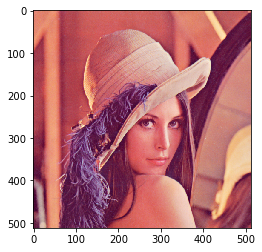

In [6]:
filepath = 'lena_std.tif'

lenna = load_image(filepath)
plt.imshow(lenna)

In [7]:
def setZeros(U, S, V, k):
    r = len(S)
    for i in range(k, r):
        U[:, i] = 0
        S[i] = 0
        V[i, :] = 0
    return U, S, V

def total_variation(S, k):
    return np.sum(S[:k]) / np.sum(S)

def img_process(img, k):
    img2 = np.zeros_like(img)
    tv = 1.0
    for c in range(img.shape[2]):
        A = img[:,:,c]
        U, S, V = svd(A)
        tv *= total_variation(S, k)
        U, S, V = setZeros(U, S, V, k)
        img2[:,:,c] = rebuildsvd(U, S, V)
    return img2, tv

In [8]:
def compression_ratio(A, k):
    denominator = A.shape[0] * A.shape[1] * A.shape[2]
    nominator = (A.shape[0] * k + k * A.shape[1] + k) * A.shape[2]
    return 1 - nominator/denominator

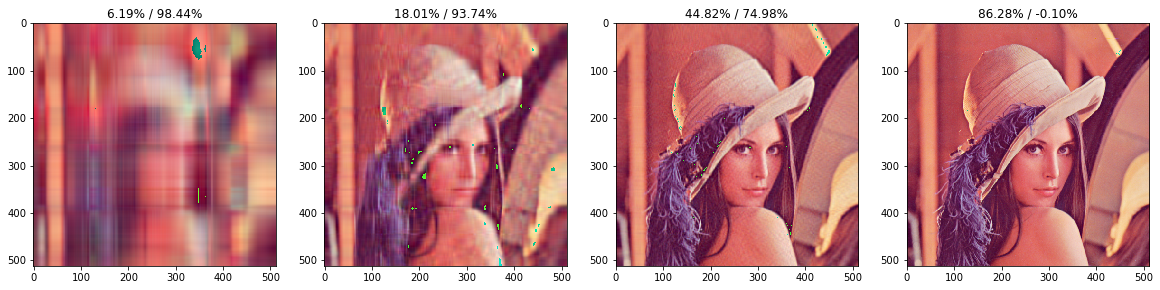

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(141)
img, variance = img_process(lenna, 4)
ratio = compression_ratio(lenna, 4)
plt.imshow(img)
plt.title('{:.2%} / {:.2%}'.format(variance, ratio))

plt.subplot(142)
img, variance = img_process(lenna, 4 ** 2)
ratio = compression_ratio(lenna, 4 ** 2)
plt.imshow(img)
plt.title('{:.2%} / {:.2%}'.format(variance, ratio))

plt.subplot(143)
img, variance = img_process(lenna, 4 ** 3)
ratio = compression_ratio(lenna, 4 ** 3)
plt.imshow(img)
plt.title('{:.2%} / {:.2%}'.format(variance, ratio))

plt.subplot(144)
img, variance = img_process(lenna, 4 ** 4)
ratio = compression_ratio(lenna, 4 ** 4)
plt.imshow(img)
plt.title('{:.2%} / {:.2%}'.format(variance, ratio))

6% of the totoal variance, there's a very blury figure. However, it has the outline of the original.

When the total variance is 50%, the image starts to look the same as the original.

#### Rreferences:
----
Section 7.1 : Image Processing by Linear Algebra, G. Strang, [Introduction to Linear Algebra, 5th Ed](http://math.mit.edu/~gs/linearalgebra/).